# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

In [2]:
os.path.abspath('.') # gives current path

'/home/dwip.dalal/Openvivo'

In [3]:
%cd '/home/dwip.dalal/Openvivo/Text to image generation'

/home/dwip.dalal/Openvivo/Text to image generation


In [4]:
dataset = os.path.abspath('.') + "/annotations/captions_train2014.json"
with open(dataset, 'r') as f:
    data = json.load(f) #loaded the annotations file in annotations 

In [5]:
data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [6]:
image_path_to_caption = collections.defaultdict(list)
for val in data['annotations']:
  caption = "<start> " + val['caption'] + " <end>"
  image_path =  os.path.abspath('.') + '/train2014/' + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [7]:
print(next(iter(image_path_to_caption.keys()))) #here we can see that the list of image path forms the key of image_path_To_caption

/home/dwip.dalal/Openvivo/Text to image generation/train2014/COCO_train2014_000000318556.jpg


In [8]:
len(list(image_path_to_caption.keys()))

82783

In [9]:
# image_path_to_caption

In [10]:
train_image_paths = list(image_path_to_caption.keys())[:6000]
random.shuffle(train_image_paths)

In [11]:
train_captions = []
image_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  image_vector.extend([image_path]*len(caption_list))# since there are 5 captions in each so there here we shall multiply it with len(caption_list)
# if we wanted we could also have multiplied it with 5 instead of caption_list but ig caption_list seem better to do so I am moving on with it


<start> a brown and yellow bathroom with a toilet tub a mirror and a sink <end>


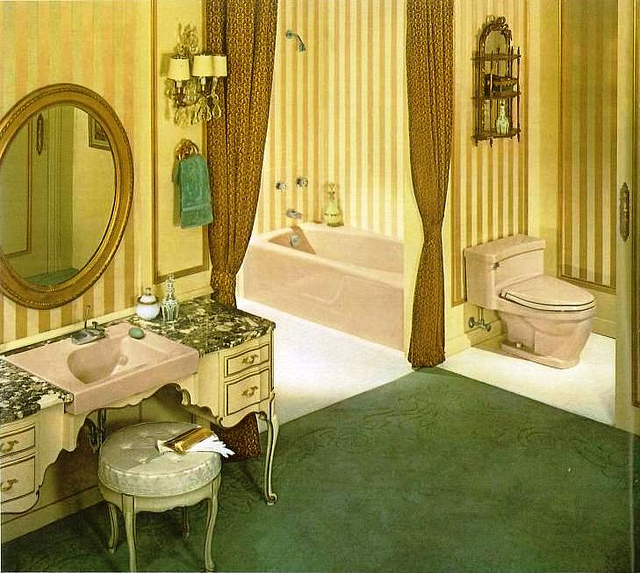

In [12]:
print(train_captions[6])
Image.open(image_vector[6])

In [13]:
def get_img(path):
    return Image.open(path).convert('RGB')


In [14]:
def resize_img(path, image_size):
    img = get_img(path)
    img = img.resize(image_size, PIL.Image.BILINEAR)
    
    return img

In [15]:
def get_img_array(path, image_size):
    return np.array(resize_img(path, image_size))

/tmp/ipykernel_202208/2592404788.py:3: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize(image_size, PIL.Image.BILINEAR)


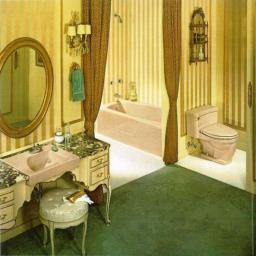

In [16]:
resize_img(image_vector[6], (256,256))

In [17]:
get_img_array(image_vector[40],(64,64)).shape

/tmp/ipykernel_202208/2592404788.py:3: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize(image_size, PIL.Image.BILINEAR)


(64, 64, 3)

In [18]:
os.path.abspath('.')

'/home/dwip.dalal/Openvivo/Text to image generation'

# next i need to load the text embedding

In [19]:
text_embedding = pickle.load(open('embedding_dict.pkl', 'rb'))

In [20]:
from collections import defaultdict
# data_dict = defaultdict(list)

In [21]:
#Print the embeddings
dic = defaultdict(list)
j = 0
for sentence, embedding in text_embedding: 
    sens = '<start> ' + sentence[7:-5] + ' <end>'
    dic[sens].append(embedding)

In [22]:
embedding.shape

(384,)

### but remember the order of the sentence in the train caption is different from those in the text_embbeding so now let's fix this thing

In [25]:
len(set(list(train_captions)))

29579

In [26]:
list_embeddings = []
z = 0
for i in train_captions:
    list_embeddings.append(dic[i])
    

In [27]:
len(list_embeddings)

30015

# Model architecture

In [28]:
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]
    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean
    return c

In [29]:
def build_ca_model():
#     Novel technique for smoothness in conditioning manifold
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(384,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [30]:
def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(384,))
    x = Dense(128)(input_layer)
    x = ReLU()(x)

    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [31]:
def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(384,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen

In [32]:
def build_stage1_discriminator():
    """
    Create a model which takes two inputs
    1. One from above network
    2. One from the embedding layer
    3. Concatenate along the axis dimension and feed it to the last module which produces final logits
    """
    input_layer = Input(shape=(64, 64, 3))

    x = Conv2D(64, (4, 4),
               padding='same', strides=2,
               input_shape=(64, 64, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([x, input_layer2])

    x2 = Conv2D(64 * 8, kernel_size=1,
                padding="same", strides=1)(merged_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)

    stage1_dis = Model(inputs=[input_layer, input_layer2], outputs=[x2])
    return stage1_dis

In [33]:
def build_adversarial_model(gen_model, dis_model):
    input_layer = Input(shape=(384,))
    input_layer2 = Input(shape=(100,))
    input_layer3 = Input(shape=(4, 4, 128))

    x, mean_logsigma = gen_model([input_layer, input_layer2])

    dis_model.trainable = False
    valid = dis_model([x, input_layer3])

    model = Model(inputs=[input_layer, input_layer2, input_layer3], outputs=[valid, mean_logsigma])
    return model

In [34]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss
    

def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)

# some other utility function to save images

In [35]:
def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()
    
def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

In [36]:
image_size = 64
batch_size = 256
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs = 1000
condition_dim = 128

In [37]:
dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

/home/dwip.dalal/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
ca_model = build_ca_model()
ca_model.compile(loss="binary_crossentropy", optimizer="adam")

2022-04-20 05:08:45.210658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-20 05:08:50.537785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 280 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2022-04-20 05:08:50.538786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1201 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2022-04-20 05:08:50.539546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/d

In [39]:
stage1_dis = build_stage1_discriminator()
stage1_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

In [40]:
stage1_gen = build_stage1_generator()
stage1_gen.compile(loss="mse", optimizer=gen_optimizer)

In [41]:
embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss="binary_crossentropy", optimizer="adam")

In [42]:
adversarial_model = build_adversarial_model(gen_model=stage1_gen, dis_model=stage1_dis)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                              optimizer=gen_optimizer, metrics=None)

In [43]:
tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
tensorboard.set_model(stage1_gen)
tensorboard.set_model(stage1_dis)
tensorboard.set_model(ca_model)
tensorboard.set_model(embedding_compressor_model)

In [44]:
real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

In [45]:
X_train = np.array(train_captions)

In [46]:
import tqdm as tqdm

In [47]:
y_train_path_list = image_vector
y_train_list = [get_img_array(a, (64,64)) for a in tqdm.tqdm(y_train_path_list)]

  0%|                                                                                               | 0/30015 [00:00<?, ?it/s]/tmp/ipykernel_202208/2592404788.py:3: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize(image_size, PIL.Image.BILINEAR)
100%|██████████████████████████████████████████████████████████████████████████████████| 30015/30015 [03:22<00:00, 148.53it/s]


In [48]:
X_train = np.array(y_train_list)

In [49]:
X_train.shape[0]

30015

In [50]:
lis_embed = []
for i in list_embeddings:
    lis_embed.append(i[0])

In [51]:
lis_embed = np.array(lis_embed)

In [52]:
lis_embed.shape

(30015, 384)

In [53]:
embedding_test = lis_embed[:300,:]

In [54]:
embedding_test.shape

(300, 384)

In [55]:
for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)
        print("Number of batches", int(X_train.shape[0] / batch_size))
        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_train.shape[0] / batch_size)
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))
            
            
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            image_batch = X_train[index * batch_size:(index + 1) * batch_size]
            embedding_batch = lis_embed[index * batch_size:(index + 1) * batch_size]
#             print(image_batch)
            image_batch = (image_batch - 127.5) / 127.5
            
            # Generate fake images
            fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)
            
            # Generate compressed embeddings
            compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))
            
            
            dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))
            
            
            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

            print("d_loss_real:{}".format(dis_loss_real))
            print("d_loss_fake:{}".format(dis_loss_fake))
            print("d_loss_wrong:{}".format(dis_loss_wrong))
            print("d_loss:{}".format(d_loss))
            
            """
            Train the generator network 
            """
            g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)
            
            
        """
        Save losses to Tensorboard after each epoch
        """
#         write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
#         write_log(tensorboard, 'generator_loss', np.mean(gen_losses[0]), epoch)
        
        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
            embedding_batch = embedding_test[0:batch_size,:]
            fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

            # Save images
            for i, img in enumerate(fake_images[:10]):
                save_rgb_img(img, "results/gen_{}_{}.png".format(epoch, i))

#     # Save models
#     stage1_gen.save_weights("stage1_gen.h5")
#     stage1_dis.save_weights("stage1_dis.h5")